### Split into Train / Valid / Test

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [3]:
df = pd.DataFrame(california.data, columns=california.feature_names)
df['TARGET'] = california.target

df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


### Convert to pytorch

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F

In [5]:
data = torch.from_numpy(df.values).float()

x = data[:, :-1]
y = data[:, -1:]

print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [6]:
ratios = [.6, .2, .2]

In [7]:
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d" % (train_cnt, valid_cnt, test_cnt))

Train 12384 / Valid 4128 / Test 4128


In [8]:
# shuffle before split
indices = torch.randperm(x.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


### preprocessing

In [9]:
scaler = StandardScaler()
scaler.fit(x[0].numpy()) # fit only train

x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()

df = pd.DataFrame(x[0].numpy(), columns=california.feature_names)
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12379,0.824651,0.588071,0.394206,-0.063281,-0.581771,0.040728,-0.698756,0.766810
12380,1.303221,-0.369220,0.641312,-0.172026,0.271218,0.084110,-0.895444,0.786813
12381,-0.774504,1.864458,-0.324408,0.063175,-0.563585,-0.003542,1.024615,-1.338953
12382,-1.148814,0.827393,-0.787743,-0.014506,-0.050060,-0.130837,0.635921,-1.233912
12383,-0.311758,0.827393,-0.391425,-0.128473,-0.539338,-0.046699,-0.689390,0.776812


### Build Model, optimizer

In [10]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [11]:
optimizer = optim.Adam(model.parameters())

### Train

In [12]:
n_epochs = 4000
batch_size = 256
print_interval = 100

In [13]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 100
lowest_epoch = np.inf

In [14]:
train_history = []
valid_history = []

for i in range(n_epochs):
    # shuffle
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    # x_ = (total_size, input_size)
    # y_ = (total_size, output_size)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    # x_ = (batch_size, input_size)
    # y_ = (batch_size, output_size)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)

        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss)

    train_loss = train_loss / len(x_)

    # valid
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)

            loss = F.mse_loss(y_hat_i, y_i)

            valid_loss += float(loss)

            y_hat += [y_hat_i]

        valid_loss = valid_loss / len(x_)

        # Log each loss to plot after training is done
        train_history += [train_loss]
        valid_history += [valid_loss]

        if (i + 1) % print_interval == 0:
            print('Epoch %d: train_loss=%.4e    valid_loss=%.4e     lowest_loss=%.4e' % (
                i + 1,
                train_loss,
                valid_loss,
                lowest_loss,
            ))

        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = i

            best_model = deepcopy(model.state_dict())
        
        else:
            if early_stop > 0 and lowest_epoch + early_stop < i + 1:
                print('There is no imporovment during last %d epochs.' % early_stop)
                break


print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))

model.load_state_dict(best_model)
            

Epoch 100: train_loss=4.1921e-01    valid_loss=4.1737e-01     lowest_loss=4.1776e-01
Epoch 200: train_loss=3.9588e-01    valid_loss=3.8482e-01     lowest_loss=3.8514e-01
Epoch 300: train_loss=3.8482e-01    valid_loss=3.7804e-01     lowest_loss=3.7762e-01
Epoch 400: train_loss=3.8252e-01    valid_loss=3.7509e-01     lowest_loss=3.7401e-01
Epoch 500: train_loss=3.8037e-01    valid_loss=3.7593e-01     lowest_loss=3.7321e-01
Epoch 600: train_loss=3.8263e-01    valid_loss=3.7494e-01     lowest_loss=3.7253e-01
Epoch 700: train_loss=3.8076e-01    valid_loss=3.7440e-01     lowest_loss=3.7212e-01
There is no imporovment during last 100 epochs.
The best validation loss from epoch 605: 3.7212e-01


<All keys matched successfully>

### Loss history

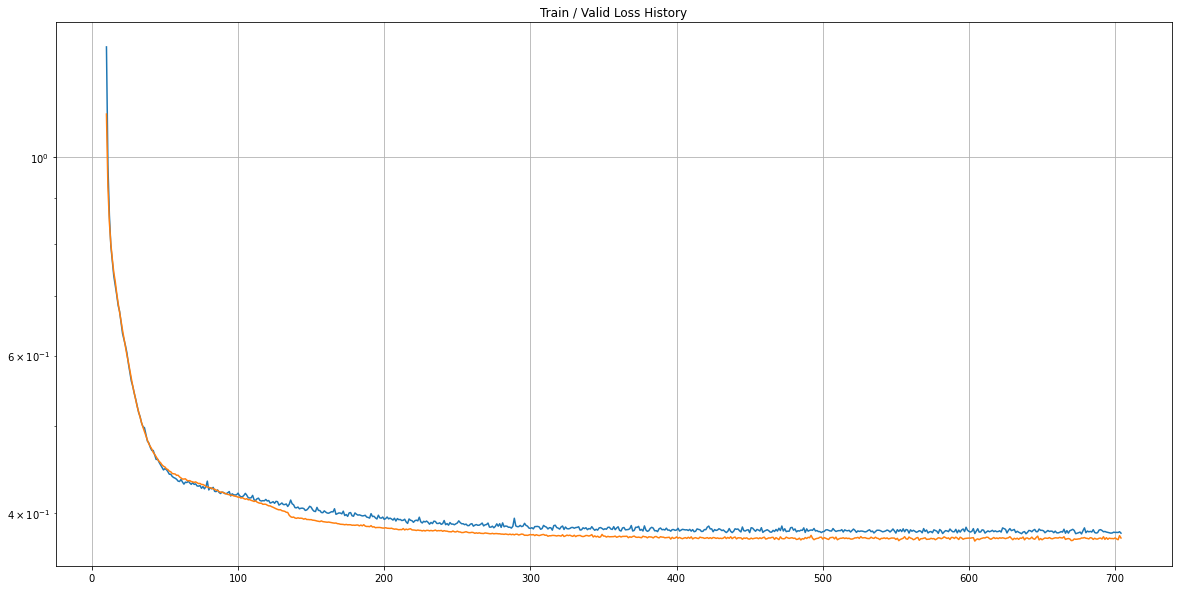

In [15]:
plot_from = 10

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

### Test

In [16]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        test_loss += loss

        y_hat += [y_hat_i]


test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print("Train loss: %.4e" % sorted_history[0][0])
print("Valid loss: %.4e" % sorted_history[0][1])
print("Test loss: %.4e" % test_loss)

Train loss: 3.7944e-01
Valid loss: 3.7212e-01
Test loss: 3.6049e-01


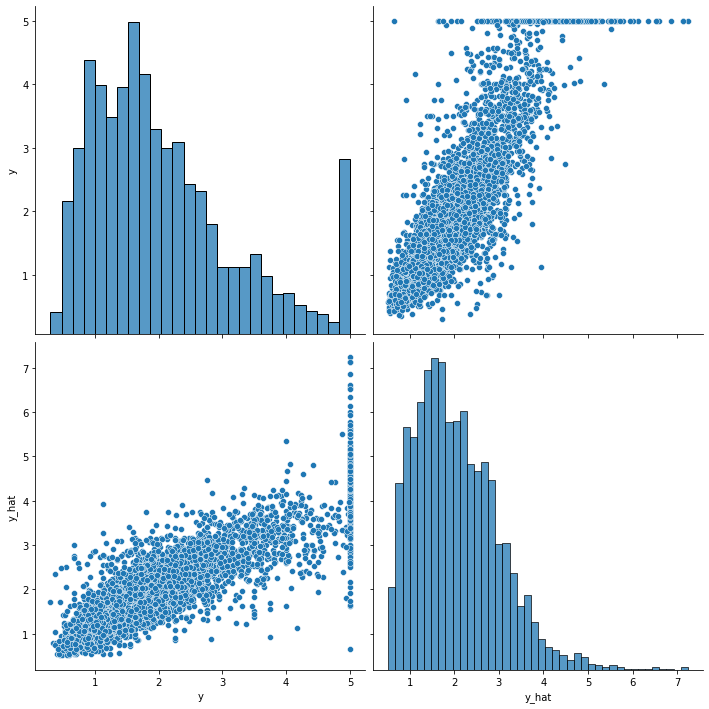

In [17]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(), columns=['y', 'y_hat'])
sns.pairplot(df, height=5)
plt.show()